<a href="https://colab.research.google.com/github/wilkieolin/VSA-notebooks/blob/main/VSA_Introduction_3_Binding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

So far, we've introduced several concepts in vector-symbolic architectures (VSAs): vector-symbols, similarity, and bundling. As a quick refresher, symbols represent concepts via long vectors of values, and the 'closeness' between these symbols is measured via a value, their similarity. We can use bundling to create a new symbol which is similar to several inputs. 

At a high level, bundling does two things: it combines information from two or more inputs into a single output, and that output will be as similar as possible to each of its inputs. The operation we'll introduce now does something different: it also combines information from two or more inputs into a single output, but this output is *not* similar to its inputs. In this tutorial, we'll show how we can accomplish this and why it's so useful.

# Graphs

In the last tutorial, we introduced a sample concept we wanted to encode in a symbol: "the cat eats the fish." Bundling alone couldn't capture the subject-object relationship we need to convey, since bundling only maintains a set of the involved objects and not their hierarchy. What we really need in this case is the ability to represent a more advanced data structure, a graph. 

Graphs consist of 'nodes' - objects which we want to represent - and 'edges,' the connections between them. A simple example of a graph is a social network, where nodes are people and edges the relationships between them. First, let's create a sample graph representing a social network using standard methods.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Create the graph
social = nx.Graph()

# Add the nodes (people) to the graph
people = ["Alice", "Bob", "Charli", "Dave", "Eve", "Zebulon"]
social.add_nodes_from(people)

In [3]:
# Add edges to the graph, describing the friendships between people

friends = [("Alice", "Bob"), 
           ("Bob", "Charli"), 
           ("Dave", "Eve"), 
           ("Alice", "Charli")]

social.add_edges_from(friends)

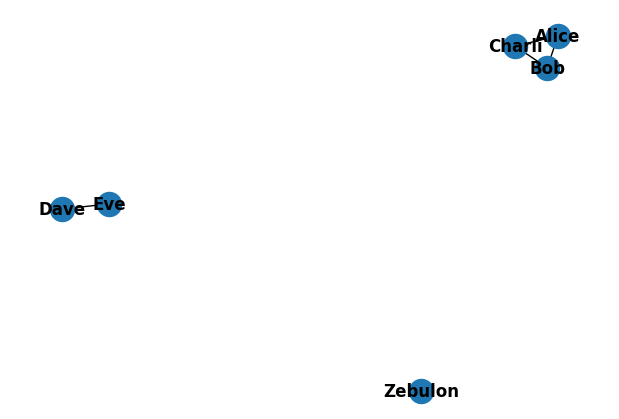

In [4]:
# Draw the graph
ax = plt.figure(dpi=100)
nx.draw(social, with_labels=True, font_weight="bold")

Even with this relatively simple graph, bundling alone isn't insufficient to represent the structure: we don't have any way to differentiate the nodes (people) from edges (friendships). What if there was a way we could construct a new symbol to represent a relationship between two people containing information from both, but dissimilar to either? *Binding* can allow us to accomplish this. 

# Binding

Below, we'll represent the binding operation with $×$. Bundling is represented with + since it resembles traditional addition. 

Similar to bundling, binding takes a set of 2 or more inputs and combines their information to create a single output. However, unlike bundling, the output of binding is dissimilar to the inputs. Binding's utility comes from the fact it is *similarity preserving*: if you measure the similarity between two symbols, bind both with third symbol, and measure the similarity between the two new symbols, the similarities will be approximately the same value:

$ A' = A × C $

$ B' = B × C $

$ sim(A, B) ≈ sim(A', B') $

Binding therefore allows us to take a group of symbols with a certain relationship (represented by similarity) and transform them to produce new symbols while preserving those previous relationships. 

If you think of a set of symbols as a a constellation of points in a hyperdimensional space, *bundling* finds the point at the center of the constellation. *Binding* instead takes each point and shifts it a distance and direction as specified by another point. If you shift each part of the constellation by the same amount, the formation ends up in a new part of the 'sky,' but the points' formation remains the same.

This is still a little abstract, so let's show how binding can be applied to represent a graph. To represent our graph, we'll start as usual by creating a series of random, dissimilar (also called *orthogonal*) vectors for each person:

In [5]:
#standard imports
import jax.numpy as jnp
from jax import random, vmap

import matplotlib.pyplot as plt

#create a helper function to generate random symbols
def generate_symbols(key, number: int, dimensionality: int):
    return random.uniform(key, minval=-1.0, maxval=1.0, shape=(number, dimensionality))

#similarity of FHRR vectors is defined by the average cosine of the difference between each angle in the two symbols being compared.
def similarity(a,b):
    assert a.shape[-1] == b.shape[-1], "VSA Dimension must match: " + str(a.shape) + " " + str(b.shape)
    #multiply values by pi to move from (-1, 1) to (-π, π)
    pi = jnp.pi
    a = jnp.multiply(a, pi)
    b = jnp.multiply(b, pi)
    #calculate the mean cosine similarity between the vectors
    similarity = jnp.mean(jnp.cos(a - b), axis=1)
    return similarity

#given two sets of symbols, measure the similarity between each pair of inputs
def similarity_outer(a,b):
    assert a.shape[1] == b.shape[1], "VSA Dimension must match: " + str(a.shape) + " " + str(b.shape)
    sim_op = lambda x: similarity(x, b)
    
    return vmap(sim_op)(a)

#create the key used to generate random values with JAX
key = random.PRNGKey(42)

#set the dimensionality of the VSA
dimensionality = 1000

In [6]:
#define the symbols we'll use to represent the people in our graph
key, subkey = random.split(key)
vsa_people = generate_symbols(subkey, len(people), dimensionality)

alice = vsa_people[0:1,:]
bob = vsa_people[1:2,:]
charli = vsa_people[2:3,:]
dave = vsa_people[3:4,:]
eve = vsa_people[4:5,:]
zebulon = vsa_people[5:6,:]

In [7]:
#plotting function to measure the similarity between the initial symbols
def plot_similarity_matrix(mat):
  plt.figure(dpi=100)
  plt.pcolor(mat)
  plt.colorbar()
  plt.title("Similarity between Symbols")
  plt.xticks(jnp.arange(0,6)+0.5, people)
  plt.yticks(jnp.arange(0,6)+0.5, people)

To begin with, we use a series of random, dissimilar symbols to describe each person. Each of these symbols is similar to itself and dissimilar to all others we've defined:

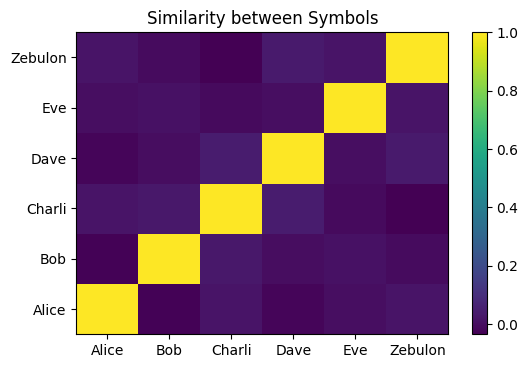

In [8]:
#measure the similarity between our original symbols
so = similarity_outer(vsa_people, vsa_people)

plot_similarity_matrix(so)

Now, we'll define the binding function and demonstrate its preservation of the initial similarity between these symbols. In this case, it means that the symbols will remain dissimilar after being bound with the new symbol.

The binding operation for the Fourier Holographic Reduced Representation (FHRR) VSA is fairly simple: the angles from each symbol are summed. You can think of this as taking the first vector, and moving each of its angles ahead by the amount in the next vector. 

Obviously, we can create an inverse operation for this ($÷$) as well - subtracting the angles we just added to get (approximately) the original symbol. The binding and unbinding functions are defined below.

In [9]:
#Bundling operation for FHRR
def bundle(*symbols):
    symbols = jnp.stack(symbols, axis=0)
    #convert each angle to a complex number
    pi = jnp.pi
    j = jnp.array([0+1j])

    #sum the complex numbers to find the bundled vector
    cmpx = jnp.exp(pi * j * symbols)
    bundle = jnp.sum(cmpx, axis=0)
    #convert the complex sum back to an angle
    bundle = jnp.angle(bundle) / pi
    bundle = jnp.reshape(bundle, (1, -1))

    return bundle

#shift angles (radian-normalized) from (-inf, inf) to (-1, 1)
def remap_phase(x):
    x = jnp.mod(x, 2.0)
    x = -2.0 * jnp.greater(x, 1.0) + x

    return x

#binding operation for FHRR
def bind(*symbols):
    #stack the vararg inputs into an array
    symbols = jnp.stack(symbols)
    #sum the angles
    symbol = jnp.sum(symbols, axis=0)
    #remap the angles to (-1, 1)
    symbol = remap_phase(symbol)
    #reshape the output to maintain 2D array
    symbol = jnp.reshape(symbol, (1, -1))

    return symbol

def unbind(x, *symbols):
    #stack and sum the symbols to be unbound
    symbols = jnp.stack(symbols, axis=0)
    symbols = jnp.sum(symbols, axis=0)

    #remove them from the input & remap phase
    symbol = jnp.subtract(x, symbols)
    symbol = remap_phase(symbol)

    return symbol

Now, let's do a quick test to show this function has the properties we've specified:

In [10]:
#create a new random symbol
key, subkey = random.split(key)
random_symbol = generate_symbols(subkey, 1, dimensionality)

#bind each of the people symbols with this new random symbol
vsa_people_2 = jnp.stack([bind(symbol, random_symbol) for symbol in [alice, bob, charli, dave, eve, zebulon]])
vsa_people_2 = jnp.squeeze(vsa_people_2)

#measure the similarity between the original symbols and bound symbols
self_similarity = similarity(vsa_people, vsa_people_2)
#measure the similarity between the bound symbols
so_2 = similarity_outer(vsa_people_2, vsa_people_2)

As we can see, after binding each of the original 'people' symbols with a new, random symbol, the bound symbols are dissimilar to the people symbols ($A ≉  A × X $):

In [11]:
self_similarity

DeviceArray([0.02290777, 0.02290776, 0.02290776, 0.02290776, 0.02290776,
             0.02290776], dtype=float32)

But, simultaneously, if we plot the similarity of the new, bound symbols to themselves, the plot is identical to before within the limits of numerical noise ($sim(A, B) ≈ sim(A × C, B × C)$):

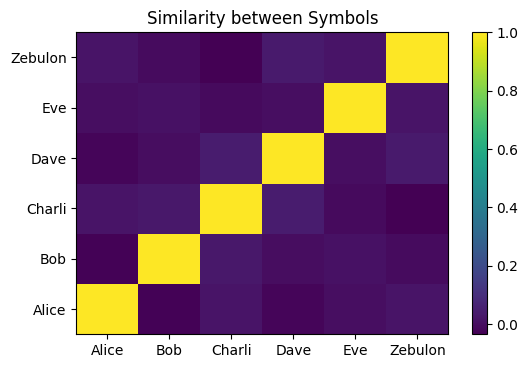

In [12]:
plot_similarity_matrix(so_2)

In [13]:
#difference in self-similarity between the original and bound symbols is approximately zero
jnp.mean(so - so_2)

DeviceArray(1.0396535e-09, dtype=float32)

# Vector-Symbolic Graphs

So, how does binding allow us to represent hierarchy in the way we'll need to construct a graph? Binding allows us to combine the symbols representing people to represent edges. 

$ Edge_0 = (Alice × Bob) $

Because of the properties of binding we demonstrated above, we know all of the new symbols we create using it will still be dissimilar to one another *and* to the original symbols:

In [14]:
#plot similarity between a symbol and the original 'people' symbols
def plot_similarity(symbol):
    plt.figure(dpi=100)
    plt.xticks(rotation=45)
    plt.bar(people, similarity(symbol, vsa_people))
    plt.ylim(0,1.1)
    plt.ylabel("Similarity")

In [15]:
edge_0 = bind(alice, bob)

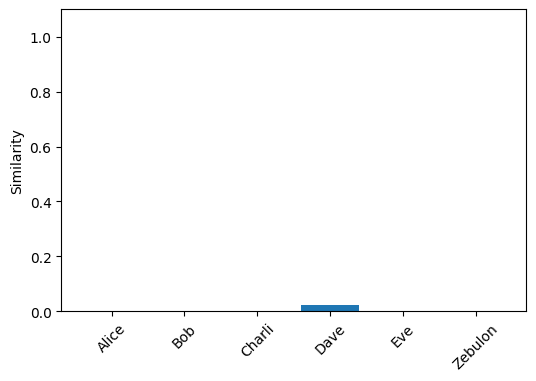

In [16]:
plot_similarity(edge_0)

This plot confirms that despite being constructed from the symbols for 'Alice' and 'Bob,' the symbol we made from binding them together isn't similar to either. Therefore, we can bundle together a series of symbols representing edges - we know that each of these symbols will be unique (dissimilar to the others) and represent a combination of two inputs. 

$ G = (Alice × Bob) + (Bob × Charli) + (Alice × Charli) + (Dave × Eve) $

In [18]:
vsa_graph = bundle(bind(alice, bob), bind(bob, charli), bind(alice, charli), bind(dave, eve))

Now, how can this representation of a graph be useful? We can use vector-symbolic operations to query it - e.g. find if a certain relationship exists in the graph:

In [19]:
# is (alice x eve) in the graph?
similarity(vsa_graph, bind(alice, eve)).item()

-0.0007699094130657613

In [20]:
# is (dave x eve) in the graph?
similarity(vsa_graph, bind(dave, eve)).item()

0.43206915259361267

Because there is no relationship between Alice and Eve encoded in the graph, there is no similarity between this symbol and the graph. Conversely, there *is* significant similarity between Dave $×$ Eve and the graph because it includes that relationship.

Let's make another query, and figure out whom Alice is friends with. To do this, we'll apply the 'unbinding' operator to the graph with $Alice$ as an argument: 

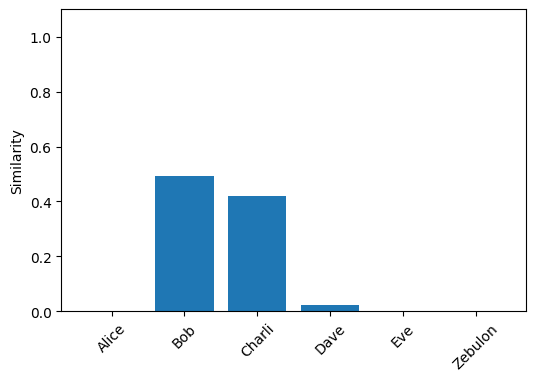

In [21]:
alice_friends = unbind(vsa_graph, alice)
plot_similarity(alice_friends)

By unbinding $Alice$ from the graph, symbols which were bound to it now become similar to their original selves. We can show this formally:

$ G = (Alice × Bob) + (Bob × Charli) + (Alice × Charli) + (Dave × Eve) $

$ G' = Alice ÷ G = Bob + Charli + (Bob × Charli ÷ Alice) + (Dave × Eve ÷ Alice) $

When we look at those last two terms, where 'Alice' doesn't cancel anything out, these terms aren't similar to anything in our list of people, so essentially these terms can be viewed as noise:

$ G' = Alice ÷ G = Bob + Charli + noise $

This is why when we look at the people $G'$ is similar to, only Bob and Charli have significant values. 

We can make more powerful queries by extending our strategy, for instance finding the friends of Alice and Eve *simultaneously* by using bundling to make a superposition of queries:

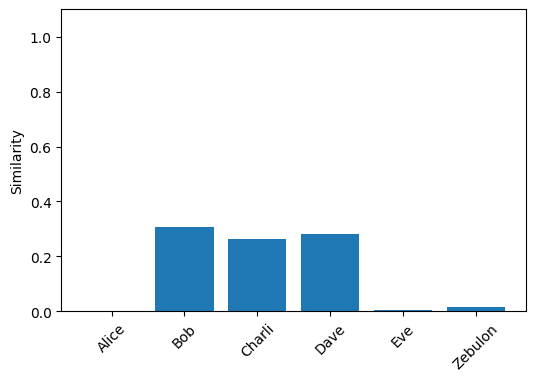

In [22]:
plot_similarity(unbind(vsa_graph, bundle(alice, eve)))

You'll notice, however, that the similarities of the positive results decrease - the results become more approximate when the query is prsented in superposition. This is one of the fundamental trade-offs of VSAs at work again: bundling more terms decreases similarity to the original symbols. This can put a limit on both the size of our queries and the number of edges we encode in a graph before accuracy degrades.

Let's look at another superposition-based query. Can we see if either Alice, Bob, or Charli is friends with Dave? If there's a connection between any of those people in the graph, it will be a binding of those individuals with Dave. Again, we can bundle Alice, Bob, and Charli together, bind this symbol with Dave, and see if it's similar to the graph:



In [23]:
similarity(vsa_graph, bind(bundle(alice, bob, charli), dave)).item()

0.03318747133016586

The resulting symbol isn't similar to the graph, so we can conclude that Dave isn't friends with either Alice, Bob, or Charli. If, however, Alice becomes friends with Dave, we can add this relationship to the graph:

In [24]:
vsa_graph_2 = bundle(bind(alice, bob), bind(bob, charli), bind(charli, alice), bind(dave, eve), bind(alice, dave))

Now the similarity of the same query becomes significant, as the new relationship is part of the graph:

In [25]:
similarity(vsa_graph_2, bind(bundle(alice, bob, charli), dave)).item()

0.19187811017036438

Again, the boundary between a 'significant' and 'insignificant' match in a VSA is not always clear, and is generally related to a degree of uncertainty. In the first notebook, we computed that the standard deviation of the similarity between random vectors with a dimensionality of 1,000 is approximately 0.023. With this result, we can state that a similarity score of 0.192 is over 8 times the standard deviation, making the result highly unlikely to be due to chance similarity between symbols. 



# Conclusion

We've now introduced the fundamental building blocks of vector-symbolic architectures: similarity, bundling, and binding. With these three operations, we can represent increasingly complex objects. In this notebook, we represented an (undirected) graph using a vector-symbolic architecture and showed that we could use these operations to make complex queries on the graph efficiently. In contrast to standard representations of graphs, where nodes are objects in memory and edges pointers linking them together, a vector-symbolic representation of a graph contains the entire representation of a graph within a single object. Queries are not made by dereferencing pointers to traverse the graph, but by constructing new symbols and measuring their similarity to the graph's representation. As we saw, this allows us to make complex queries in a single step, though the results are probabilistic rather than deterministic. 

Bundling and binding allow us to engineer the similarity between symbols to represent structured knowledge. So far, we've used these operations to represent sets and graphs. VSAs aren't limited to only these structures, and other works have [represented images, sequences, and more with VSAs](https://arxiv.org/abs/2111.06077). 

Sometimes, we may not be able to design the structures we need to solve a problem by using a set of random symbols and the VSA operations; there may be too many possible inputs, or there are existing relationships between symbols we can't clearly describe using rules and hierarchies. In the next notebook, we'll explore how neural networks can integrate with VSAs to provide this 'missing piece' of the puzzle. 